<a href="https://colab.research.google.com/github/ameykasbe/CS540_app_review/blob/master/E_commerce_appStore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import pandas as pd
pd.set_option('display.max_rows', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv("/content/drive/MyDrive/CS540/e_commerce_app_store.csv")

In [6]:
df = df.drop(labels = ['Unnamed: 0', 'review_id','isEdited', 'user_name', 'developer_response_date', 'thumbs_up', 'laguage_code', 'country_code','Unnamed: 14'], axis = 1)

In [9]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
def preprocess_text(text):
    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('utf-8')
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove alphanumeric characters
    text = re.sub(r'\w*\d\w*', '', text).strip()
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Join the filtered tokens back into a string
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text



In [11]:
# Apply the preprocessing function to the dataframe columns
df['preprocessed_reviews'] = df['review_description'].apply(preprocess_text)
df['preprocessed_review_titles'] = df['review_title'].apply(preprocess_text)

In [12]:
average_rating = df.groupby('appName')['rating'].mean()
average_rating.sort_values(ascending = False)

In [16]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon') # Download the VADER lexicon
sia = SentimentIntensityAnalyzer() # Initialize the sentiment analyzer


sentiment_scores = []
for review in df['preprocessed_reviews']:
    scores = sia.polarity_scores(review)
    compound_score = scores['compound']
    if compound_score > 0:
        sentiment = "Positive"
    elif compound_score < 0:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"

    sentiment_scores.append(sentiment)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [42]:
df['sentiment_scores'] = sentiment_scores

In [17]:
amazon_reviews = df[df['appName'] == 'Amazon']['preprocessed_reviews']

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Initialize CountVectorizer to convert text data into a bag of words representation
vectorizer = CountVectorizer(max_features= None, max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the preprocessed_reviews to a bag of words
bow = vectorizer.fit_transform(amazon_reviews)

# Initialize the LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=0)

# Fit the LDA model on the bag of words data
lda.fit(bow)

# Print the top 10 words for each of the 10 topics
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-29:-1]]))
    print()

Topic #0:
package dont refund number know told address order app account customer got card shipping change work received stuff want trying touch message say send time days im delivered

Topic #1:
search items filter app results item like need dont want filters people list service price select time order way prime looking department type yall products use customer different

Topic #2:
app like time list click page reviews search items version right product dont item update ive order want screen ipad way im iphone use things scroll problem change

Topic #3:
search app time results ipad item items used order pay like account shopping way want doesnt arrive work making prices anymore right page actually date shipping using looking

Topic #4:
im app order page product delivery new search scroll customer instead service dont ive update products make work got package way reviews didnt people screen things link left

Topic #5:
item app dont service im return way refund list items thats doesnt 

In [20]:
import spacy

In [21]:
nlp = spacy.load("en_core_web_sm")

In [22]:
def extract_keywords(text):
    doc = nlp(text)
    keywords = [token.text for token in doc if not token.is_stop and token.is_alpha and len(token)>2][:10]
    return keywords

In [23]:
df['keywords'] = df['preprocessed_reviews'].apply(lambda x: extract_keywords(x))

In [24]:
data = {'Topic': ['1', '2', '3', '4', '5', '6','7', '8', '9', '10'],
        'Text': ['package dont refund number know told address order app account customer got card shipping change work received stuff want trying touch message say send time days im delivered',
                 'search items filter app results item like need dont want filters people list service price select time order way prime looking department type yall products use customer different',
                 'pp like time list click page reviews search items version right product dont item update ive order want screen ipad way im iphone use things scroll problem change',
                 'search app time results ipad item items used order pay like account shopping way want doesnt arrive work making prices anymore right page actually date shipping using looking',
                 'im app order page product delivery new search scroll customer instead service dont ive update products make work got package way reviews didnt people screen things link left',
                 'item app dont service im return way refund list items thats doesnt purchase able time know order delivery really update use different ive company understand years section frustrating',
                 'app items im cart like button item use things wrong search dont page order screen shopping card need good using used option orders different time instead add looking',
                 'app list product search things update items item repeat page want wish results need stop makes open new lists really ive time going example pages constantly left sort',
                 'app dont items time people orders page use want buy shipping delivered delivery days word question issue say bad process im gone issues new problem list money zoom',
                 'app im time share products shipping order use like using product know prime option ipad want ive money information orders delivery website items people day customer used packages']}


amazon_df = pd.DataFrame(data)

In [25]:
amazon_df['keywords'] = amazon_df['Text'].apply(lambda x: extract_keywords(x))

In [26]:
amazon_df['keywords']

0    [package, refund, number, know, told, address,...
1    [search, items, filter, app, results, item, li...
2    [like, time, list, click, page, reviews, searc...
3    [search, app, time, results, ipad, item, items...
4    [app, order, page, product, delivery, new, sea...
5    [item, app, service, return, way, refund, list...
6    [app, items, cart, like, button, item, use, th...
7    [app, list, product, search, things, update, i...
8    [app, items, time, people, orders, page, use, ...
9    [app, time, share, products, shipping, order, ...
Name: keywords, dtype: object

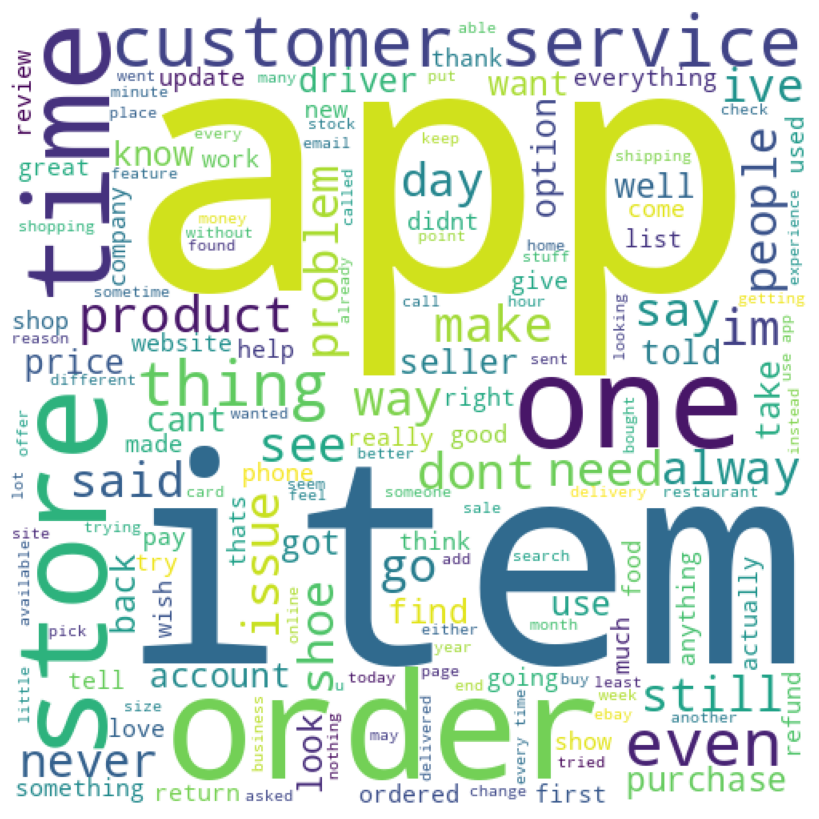

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# combine text from all rows of the column into one string
text = " ".join(review for review in df['preprocessed_reviews'])

# Assuming 'text' is a string containing all the text data
wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(text) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

In [28]:
train_set = df[0:6000]
valid_set = df[6000:9400]

In [29]:
import nltk
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [30]:
train_set.columns

Index(['appName', 'source', 'review_date', 'review_description', 'rating',
       'review_title', 'preprocessed_reviews', 'preprocessed_review_titles',
       'keywords'],
      dtype='object')

In [31]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment_result(sent):
    scores = analyzer.polarity_scores(sent)
    
    if scores["neg"] > scores["pos"]:
        return 0

    return 1

train_set["vader_result"] = train_set["preprocessed_reviews"].apply(lambda x: vader_sentiment_result(x))
valid_set["vader_result"] = valid_set["preprocessed_reviews"].apply(lambda x: vader_sentiment_result(x))

<ipython-input-31-635179e4c246>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set["vader_result"] = train_set["preprocessed_reviews"].apply(lambda x: vader_sentiment_result(x))
<ipython-input-31-635179e4c246>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_set["vader_result"] = valid_set["preprocessed_reviews"].apply(lambda x: vader_sentiment_result(x))


In [32]:
pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.1 MB/s eta 0:00:00


In [33]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [51]:
data = list(amazon_reviews)
sentiments = sentiment_pipeline(data)
sentiments

[{'label': 'NEGATIVE', 'score': 0.9987275004386902},
 {'label': 'NEGATIVE', 'score': 0.9970762729644775},
 {'label': 'NEGATIVE', 'score': 0.9974026083946228},
 {'label': 'NEGATIVE', 'score': 0.9975314140319824},
 {'label': 'NEGATIVE', 'score': 0.9818629622459412},
 {'label': 'NEGATIVE', 'score': 0.9989333748817444},
 {'label': 'NEGATIVE', 'score': 0.9992790818214417},
 {'label': 'NEGATIVE', 'score': 0.9992551207542419},
 {'label': 'NEGATIVE', 'score': 0.9708231091499329},
 {'label': 'NEGATIVE', 'score': 0.9924331903457642},
 {'label': 'NEGATIVE', 'score': 0.9966827034950256},
 {'label': 'NEGATIVE', 'score': 0.9977988600730896},
 {'label': 'NEGATIVE', 'score': 0.9980829954147339},
 {'label': 'NEGATIVE', 'score': 0.9828730225563049},
 {'label': 'NEGATIVE', 'score': 0.9966146349906921},
 {'label': 'NEGATIVE', 'score': 0.9992619156837463},
 {'label': 'NEGATIVE', 'score': 0.999175488948822},
 {'label': 'POSITIVE', 'score': 0.9957101345062256},
 {'label': 'NEGATIVE', 'score': 0.9960750937461

In [53]:
sentiments_labels = [item['label'] for item in sentiments]
sentiments_labels

ValueError: ignored

#EDA